### Get clean descriptions of wine under 50€ (min 3 flavors)

In [ ]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer

# Load the spaCy model for NLP
nlp = spacy.load("en_core_web_sm")

# Load the cleaned wine dataset
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
cleaned_wine_data = pd.read_csv(file_path + 'cleaned_wine_data_price_max=50_desc=cleaned.csv')

# Vectorize the descriptions to find the minimal common words
vectorizer = CountVectorizer(stop_words='english', min_df=1)
X = vectorizer.fit_transform(cleaned_wine_data['processed_description'])

# Get the vocabulary and its frequency in the dataset
vocab = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)

# Sort words by frequency
sorted_vocab = [word for _, word in sorted(zip(word_counts, vocab), reverse=True)]

# Initialize a set to track all used words
used_words_set = set()

# Function to keep the minimal common words that allow all wines to have at least 3 words
def minimal_common_words(row, sorted_vocab, min_words=3):
    words = row.split()
    selected_words = [word for word in sorted_vocab if word in words]
    used_words_set.update(selected_words[:min_words])  # Track the words used
    return " ".join(selected_words[:min_words])

# Apply the function to create the new flavor column
cleaned_wine_data['minimal_flavors'] = cleaned_wine_data['processed_description'].apply(
    lambda row: minimal_common_words(row, sorted_vocab))

# Calculate the number of words in the minimal_flavors column
cleaned_wine_data['flavor_word_count'] = cleaned_wine_data['minimal_flavors'].apply(lambda x: len(x.split()))

# Get the total number of unique words used
total_unique_words_used = len(used_words_set)

# Display the first few rows and the total number of unique words used
print(cleaned_wine_data[['processed_description', 'minimal_flavors', 'flavor_word_count']].head())
print(f"Total unique words used across all wines to meet the 3-word minimum: {total_unique_words_used}")

# Save data into a new csv
cleaned_wine_data.to_csv(file_path + "cleaned_wine_data_price_max=50_desc=3flav.csv", index = False)

### Create Knowledge-Graph

#### Create 2 graphs, one for US wines and one for French wines and compare them
##### Removing other geographical information from the analysis (Country/Province/Winery and related edges)
##### Select only flavors with degree > 10 (that have been used in at least 10 wines)
- Using Interactive Visualization (Pyvis)
- Scale node sizes based on the number of connections (degree) 
- Color nodes depending on their type (wine, flavor etc.) 
- Scale edge widths to represent the strength or frequency of connections

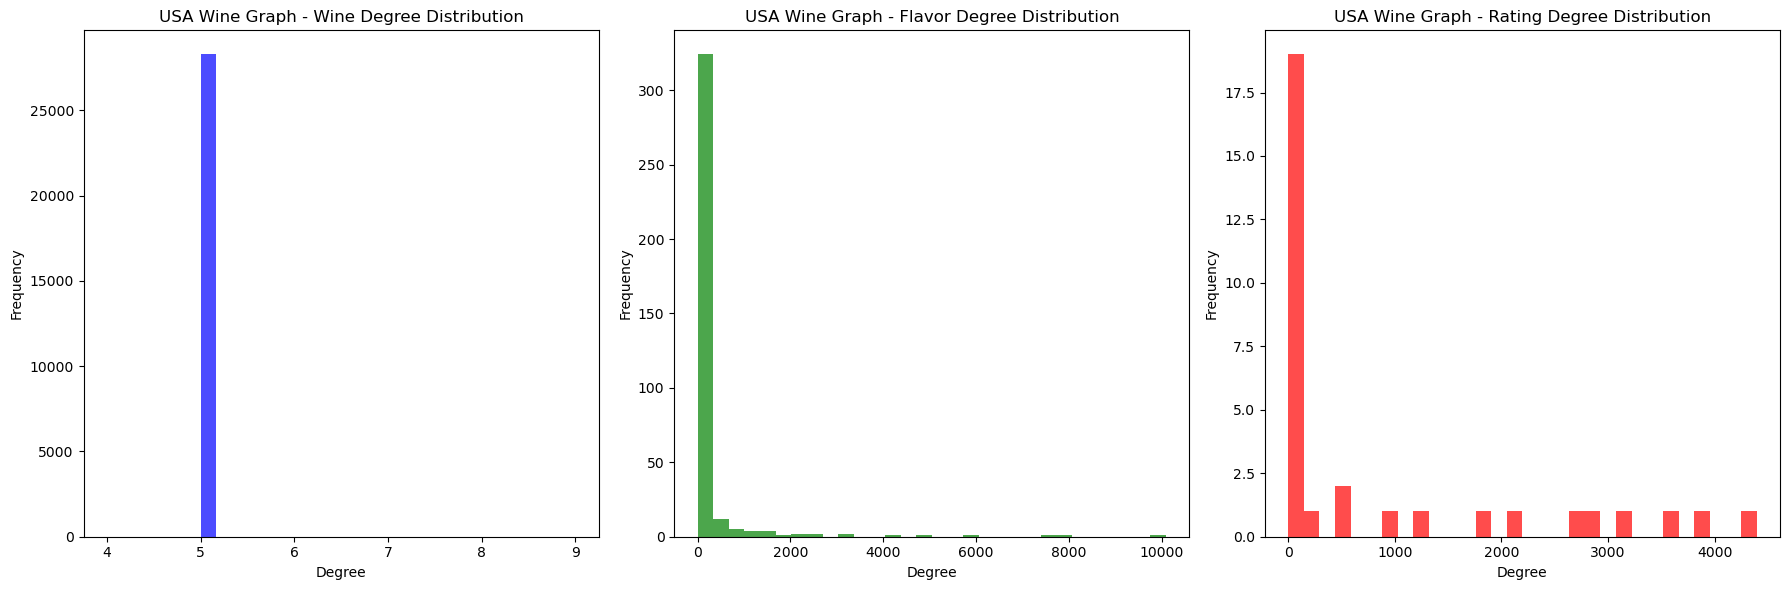

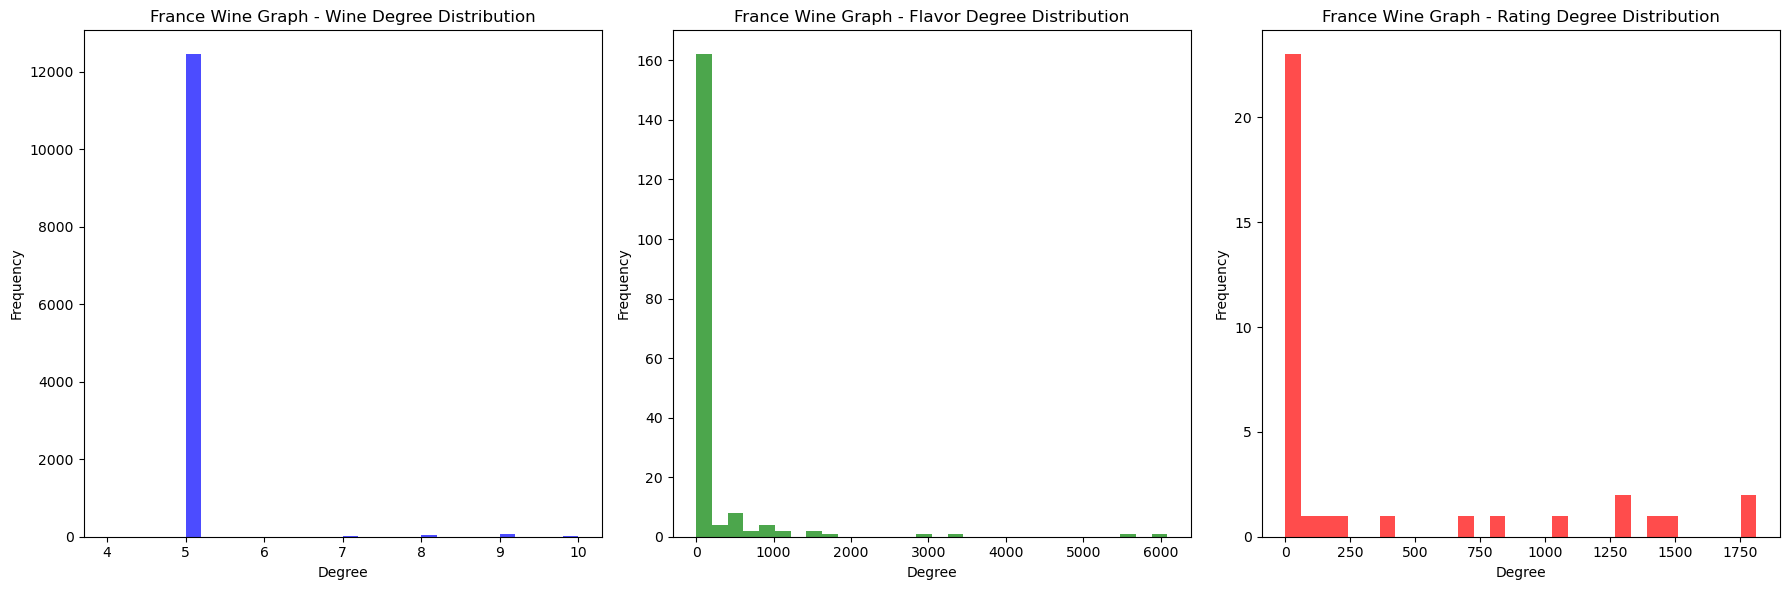

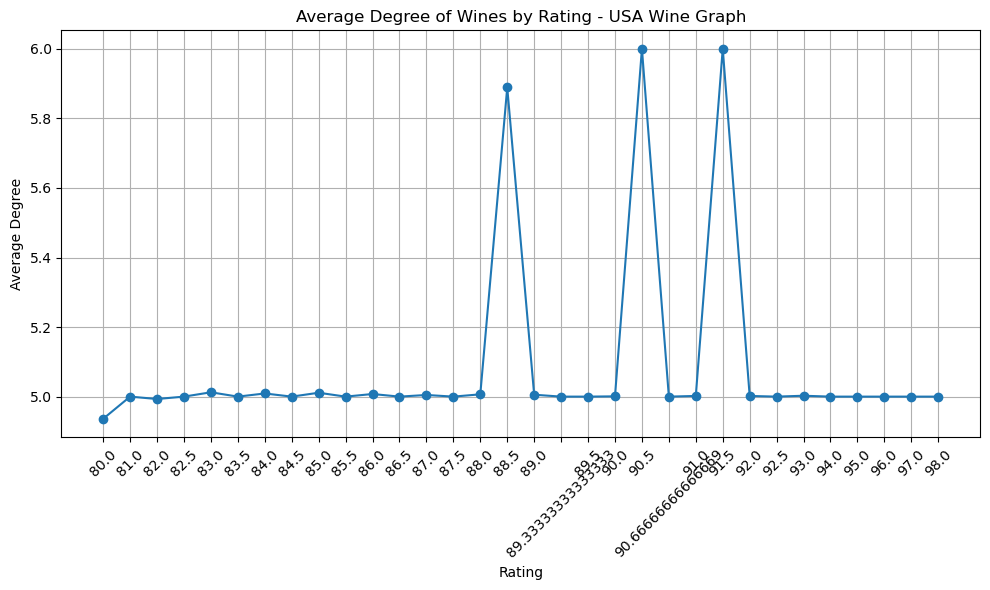

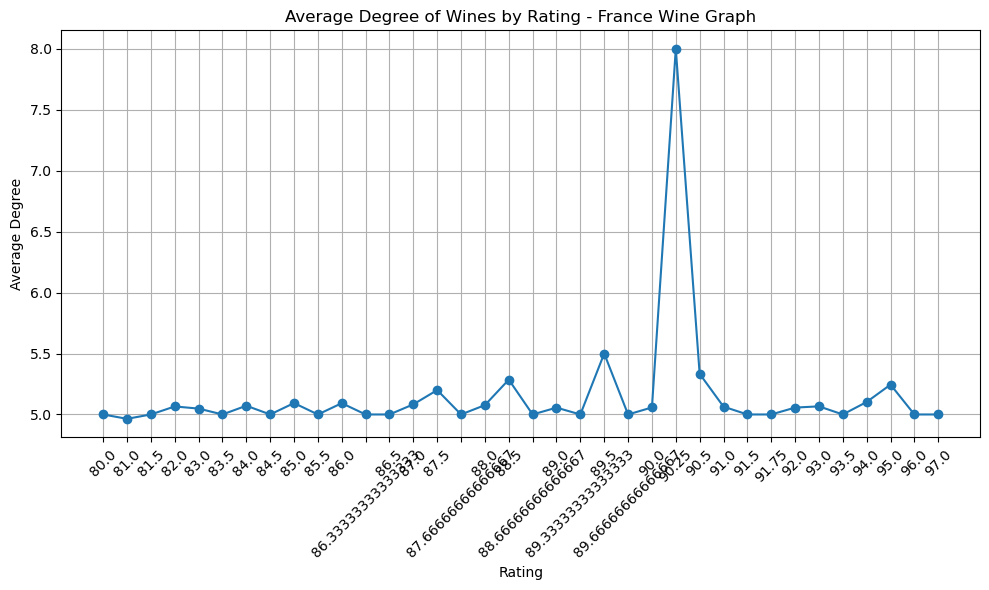

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load and filter the dataset
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'  # Replace with the correct file path
cleaned_wine_data = pd.read_csv(file_path + "cleaned_wine_data_price_max=50_desc=3flav.csv")
usa_data = cleaned_wine_data[cleaned_wine_data['country'] == 'US']
france_data = cleaned_wine_data[cleaned_wine_data['country'] == 'France']

# Function to create the wine-flavor-variety-rating graph
def create_wine_graph(data):
    G = nx.Graph()
    for _, row in data.iterrows():
        wine_node = f"Wine: {row['title']}"
        rating_node = f"Rating: {row['points']}"
        
        G.add_node(wine_node, node_type='wine')
        G.add_node(row['variety'], node_type='variety')
        G.add_node(rating_node, node_type='rating')
        
        # Connect wine to variety and rating
        G.add_edge(wine_node, row['variety'], relation='From Variety')
        G.add_edge(wine_node, rating_node, relation='Has Rating')
        
        for flavor in row['minimal_flavors'].split():
            G.add_node(flavor, node_type='flavor')
            G.add_edge(wine_node, flavor, relation='Has Flavor')
    
    return G

# Create graphs for USA and France
usa_graph = create_wine_graph(usa_data)
france_graph = create_wine_graph(france_data)

# Function to plot degree distribution by node type
def plot_degree_distribution(G, title):
    wine_degrees = [d for n, d in G.degree() if G.nodes[n]['node_type'] == 'wine']
    flavor_degrees = [d for n, d in G.degree() if G.nodes[n]['node_type'] == 'flavor']
    rating_degrees = [d for n, d in G.degree() if G.nodes[n]['node_type'] == 'rating']
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.hist(wine_degrees, bins=30, color='blue', alpha=0.7)
    plt.title(f"{title} - Wine Degree Distribution")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(flavor_degrees, bins=30, color='green', alpha=0.7)
    plt.title(f"{title} - Flavor Degree Distribution")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(rating_degrees, bins=30, color='red', alpha=0.7)
    plt.title(f"{title} - Rating Degree Distribution")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot the degree distributions for USA and France graphs
plot_degree_distribution(usa_graph, "USA Wine Graph")
plot_degree_distribution(france_graph, "France Wine Graph")


# Function to analyze how ratings influence degree
def analyze_rating_influence_on_degree(G, title):
    rating_degrees = {}
    
    # Calculate the degree of each wine node and associate it with its rating
    for node, degree in G.degree():
        if G.nodes[node]['node_type'] == 'wine':
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor]['node_type'] == 'rating':
                    rating = neighbor.split(': ')[1]
                    if rating not in rating_degrees:
                        rating_degrees[rating] = []
                    rating_degrees[rating].append(degree)
    
    # Calculate average degree for each rating
    avg_degree_by_rating = {rating: sum(degrees) / len(degrees) for rating, degrees in rating_degrees.items()}
    
    # Sort ratings for better plotting
    sorted_ratings = sorted(avg_degree_by_rating.keys(), key=lambda x: float(x))
    sorted_avg_degrees = [avg_degree_by_rating[rating] for rating in sorted_ratings]
    
    # Plot the relationship
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_ratings, sorted_avg_degrees, marker='o')
    plt.title(f"Average Degree of Wines by Rating - {title}")
    plt.xlabel("Rating")
    plt.xticks(rotation=45)
    plt.ylabel("Average Degree")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Analyze and plot rating influence on degree for USA and France graphs
analyze_rating_influence_on_degree(usa_graph, "USA Wine Graph")
analyze_rating_influence_on_degree(france_graph, "France Wine Graph")


In [ ]:

# Centrality Measures Analysis
def plot_centrality(G, title):
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G)
    
    centrality_df = pd.DataFrame({
        'Node': list(G.nodes()),
        'Betweenness': list(betweenness.values()),
        'Closeness': list(closeness.values()),
        'Eigenvector': list(eigenvector.values())
    })
    
    centrality_df.plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.show()

plot_centrality(usa_graph, "USA Wine Graph Centrality")
plot_centrality(france_graph, "France Wine Graph Centrality")

# Community Detection Analysis
def plot_communities(G, title):
    communities = louvain_communities(G)
    community_map = {node: idx for idx, community in enumerate(communities) for node in community}
    nx.draw(G, node_color=[community_map[node] for node in G.nodes()], with_labels=True)
    plt.title(title)
    plt.show()

plot_communities(usa_graph, "USA Wine Graph Communities")
plot_communities(france_graph, "France Wine Graph Communities")

# Flavor Co-occurrence Analysis
def plot_flavor_cooccurrence(G, title):
    flavor_edges = [(u, v) for u, v in G.edges() if G.nodes[u]['type'] == 'flavor' and G.nodes[v]['type'] == 'flavor']
    flavor_subgraph = G.edge_subgraph(flavor_edges)
    nx.draw(flavor_subgraph, with_labels=True, node_color='purple')
    plt.title(title)
    plt.show()

plot_flavor_cooccurrence(usa_graph, "USA Flavor Co-occurrence")
plot_flavor_cooccurrence(france_graph, "France Flavor Co-occurrence")

# Flavor Diversity Index Analysis
def calculate_flavor_diversity(G):
    flavors = [n for n in G.nodes() if G.nodes[n]['type'] == 'flavor']
    flavor_counts = Counter(flavors)
    return entropy(list(flavor_counts.values()))

usa_diversity = calculate_flavor_diversity(usa_graph)
france_diversity = calculate_flavor_diversity(france_graph)
print(f"Flavor Diversity Index - USA: {usa_diversity}")
print(f"Flavor Diversity Index - France: {france_diversity}")

# Comparative Analysis of Top-Rated Wines
def plot_top_rated_wines(data, G, title):
    top_rated = data[data['points'] > 90]
    top_graph = create_wine_graph(top_rated)
    nx.draw(top_graph, with_labels=True)
    plt.title(title)
    plt.show()

plot_top_rated_wines(usa_data, usa_graph, "Top-Rated USA Wines")
plot_top_rated_wines(france_data, france_graph, "Top-Rated France Wines")

# Edge Density and Graph Density Analysis
def calculate_graph_density(G):
    density = nx.density(G)
    return density

usa_density = calculate_graph_density(usa_graph)
france_density = calculate_graph_density(france_graph)
print(f"Graph Density - USA: {usa_density}")
print(f"Graph Density - France: {france_density}")

# Network Motif Analysis (basic motif counting example)
def count_motifs(G, motif):
    # Count occurrences of a simple motif (triad) in the graph
    motif_count = 0
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if len(neighbors) > 2:
            motif_count += 1
    return motif_count

usa_motifs = count_motifs(usa_graph, 'triad')
france_motifs = count_motifs(france_graph, 'triad')
print(f"Triad Motifs - USA: {usa_motifs}")
print(f"Triad Motifs - France: {france_motifs}")